In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from planners.basic_prm import BasicPRM
from utils.collision_checker import CollisionChecker
from environment import get_all_scenes
import time
import pandas as pd
from scipy.spatial.distance import euclidean

In [16]:
def visualize_path(prm, path, scene, limits, start, goal, title=""):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Hindernisse zeichnen
    for shape in scene.values():
        xs, ys = shape.exterior.xy if hasattr(shape, 'exterior') else shape.xy
        ax.fill(xs, ys, color='lightcoral', alpha=0.7)

    pos = nx.get_node_attributes(prm.graph, 'pos')

    # Alle Knoten
    nx.draw_networkx_nodes(prm.graph, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(prm.graph, pos, alpha=0.3, ax=ax)

    # Pfad markieren
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(prm.graph, pos, edgelist=path_edges, width=3, edge_color='green', ax=ax)

    ax.plot(start[0][0], start[0][1], "go", markersize=10, label="Start")
    ax.plot(goal[0][0], goal[0][1], "ro", markersize=10, label="Ziel")

    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.title(title)
    plt.show()


🔍 Szene: U-Shape
✅ Pfad gefunden in Szene: U-Shape, Länge: 16


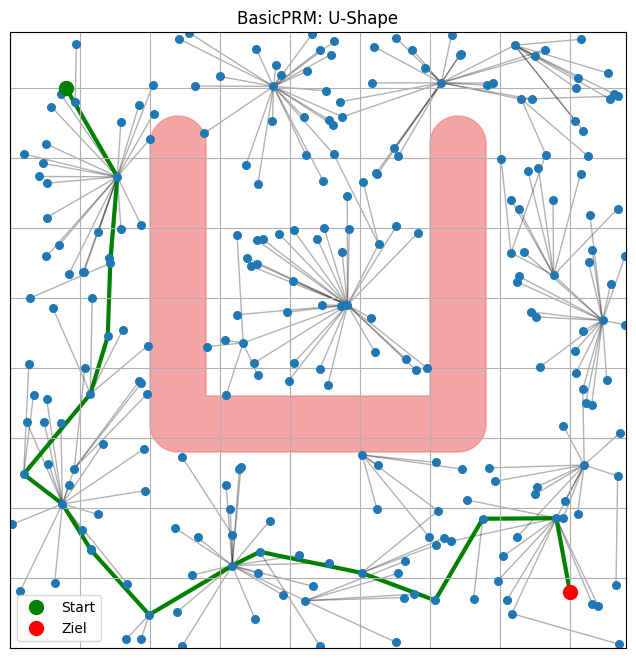


🔍 Szene: L-Shape
✅ Pfad gefunden in Szene: L-Shape, Länge: 14


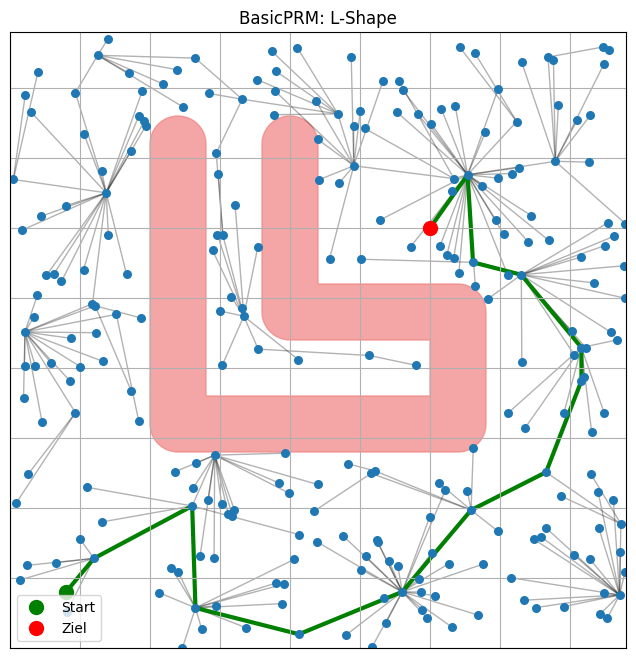


🔍 Szene: Cross-Shape
✅ Pfad gefunden in Szene: Cross-Shape, Länge: 15


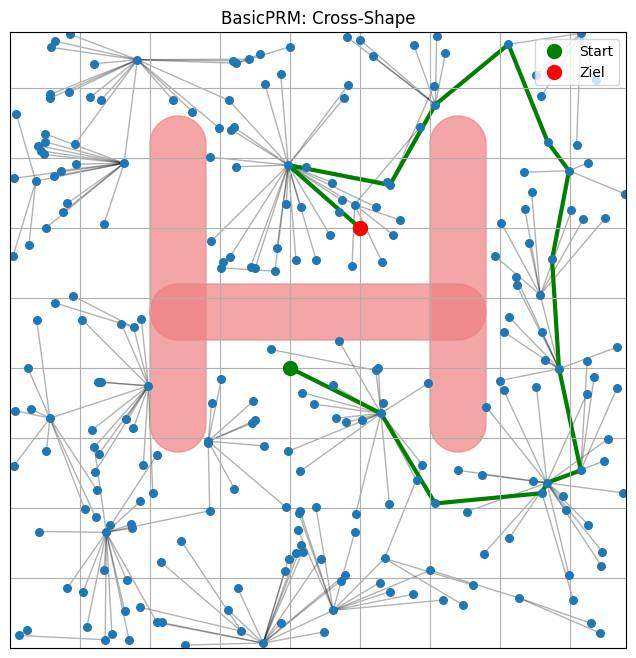


🔍 Szene: Corridor
❌ Kein Pfad gefunden in Szene: Corridor


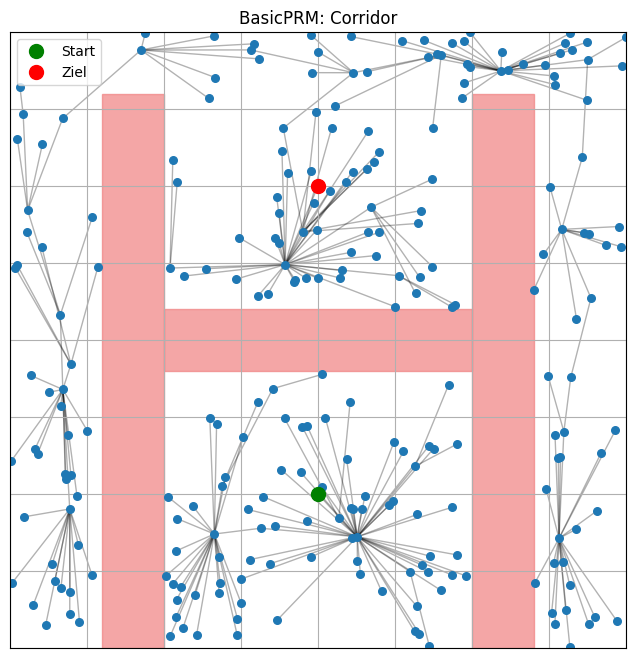


🔍 Szene: Complex Shape
✅ Pfad gefunden in Szene: Complex Shape, Länge: 19


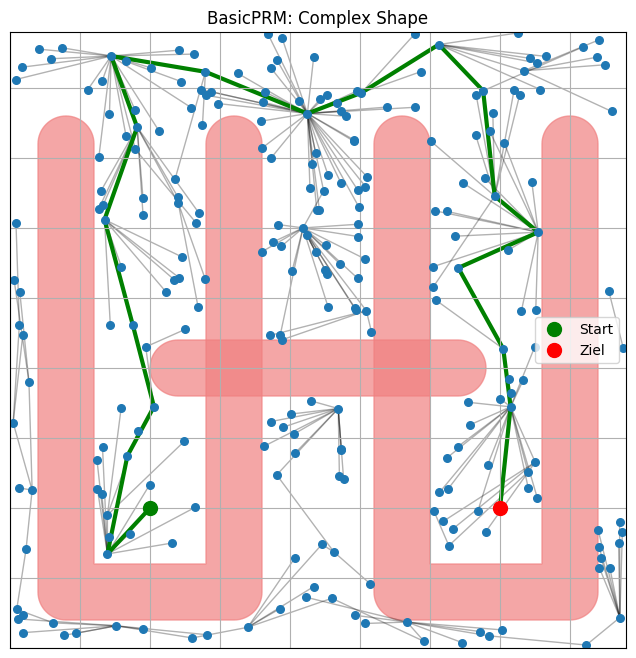


🔍 Szene: Multiple Obstacles
✅ Pfad gefunden in Szene: Multiple Obstacles, Länge: 22


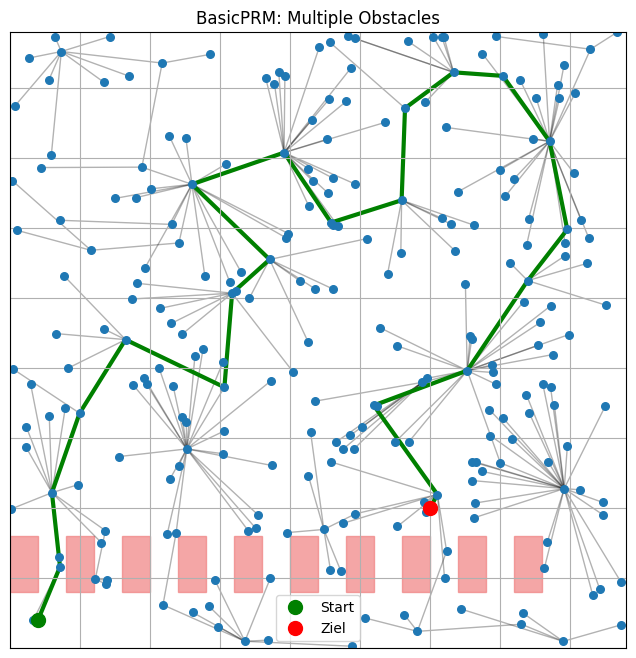


🔍 Szene: Random Obstacles
✅ Pfad gefunden in Szene: Random Obstacles, Länge: 14


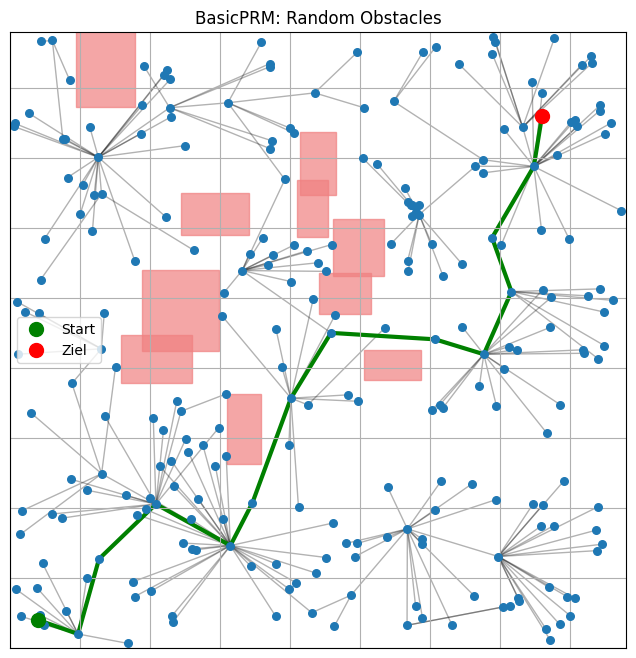

In [17]:
# ---- Alle Szenen durchlaufen + Benchmark ----
scenes = get_all_scenes()
results = []
for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Szene: {scene_name}")
    start = [list(start_pos)]
    goal = [list(goal_pos)]

    # CollisionChecker instanziieren
    collision_checker = CollisionChecker(scene, limits)

    # PRM-Planer initialisieren
    planner = BasicPRM(collision_checker, limits)

    # Planung mit Zeitmessung
    t0 = time.time()
    path = planner.plan_path(start, goal, config)
    t1 = time.time()

    coords = planner.get_path_coordinates(path) if path else []
    euclidean_length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
    else:
        print(f"✅ Pfad gefunden in Szene: {scene_name}, Länge: {len(path)}")

    # Visualisierung (optional, kann deaktiviert werden)
    visualize_path(planner, path, scene, limits, start, goal, title=f"BasicPRM: {scene_name}")

    result = {
        "scene": scene_name,
        "hasPath": bool(path),
        "length": len(path) if path else 0,
        "euclidean_length": euclidean_length,
        "time": t1 - t0,
        "nodes": len(planner.graph.nodes),
        "edges": len(planner.graph.edges),
        "roadmap_size": planner.graph.size()  # Gesamtgewicht oder Anzahl der Kanten
    }
    results.append(result)


📊 Benchmark-Ergebnisse:
                scene  hasPath  length  euclidean_length      time  nodes  \
0             U-Shape     True      16         41.785027  0.226722    252   
1             L-Shape     True      14         39.098634  0.222208    252   
2         Cross-Shape     True      15         42.594354  0.222331    252   
3            Corridor    False       0          0.000000  0.225219    252   
4       Complex Shape     True      19         53.841432  0.244784    252   
5  Multiple Obstacles     True      22         60.407432  0.249757    252   
6    Random Obstacles     True      14         33.412680  0.291463    252   

   edges  roadmap_size  
0    251           251  
1    251           251  
2    251           251  
3    250           250  
4    249           249  
5    251           251  
6    251           251  


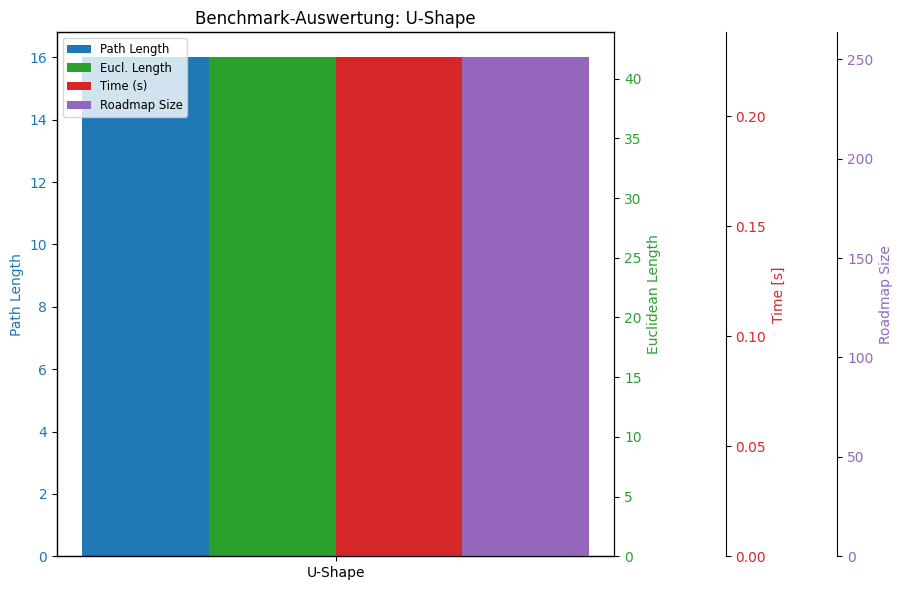

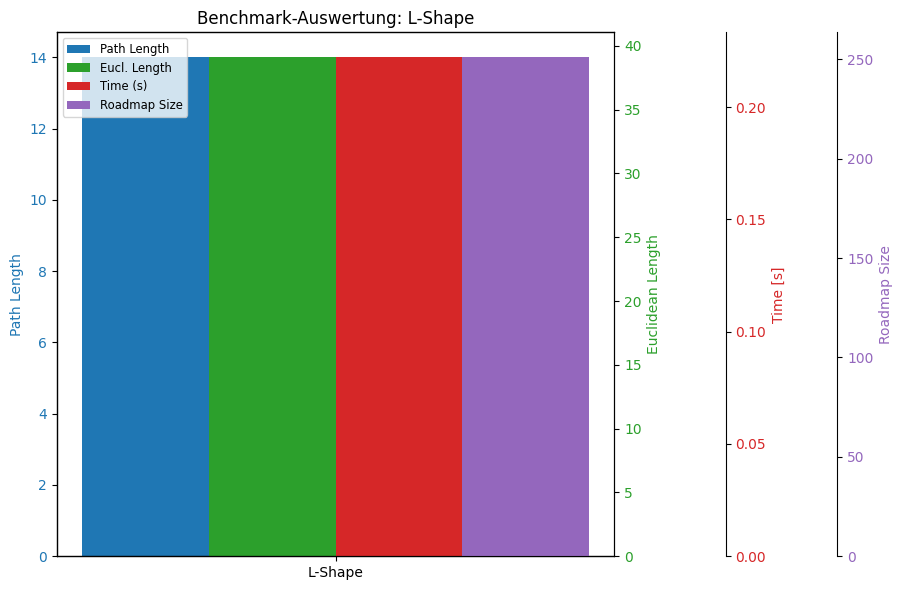

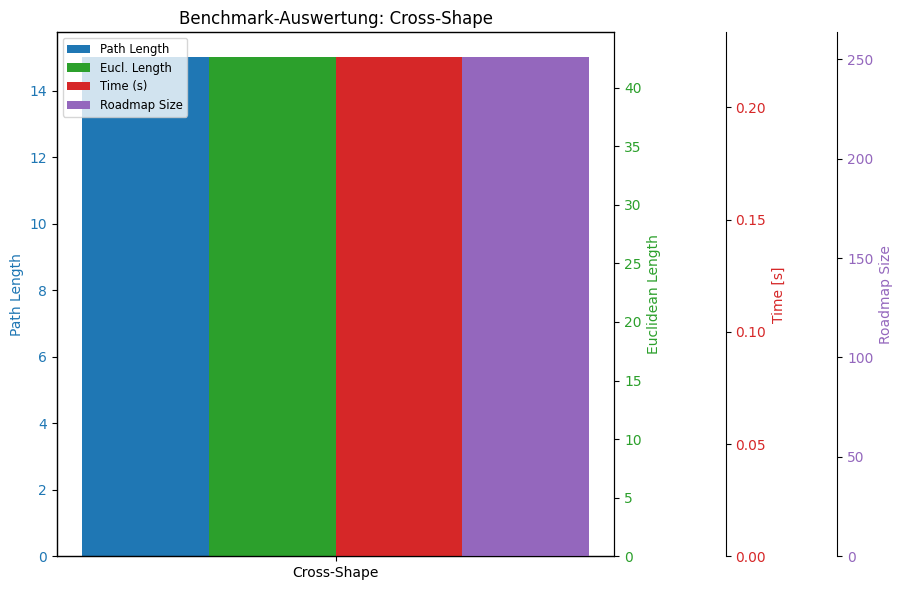

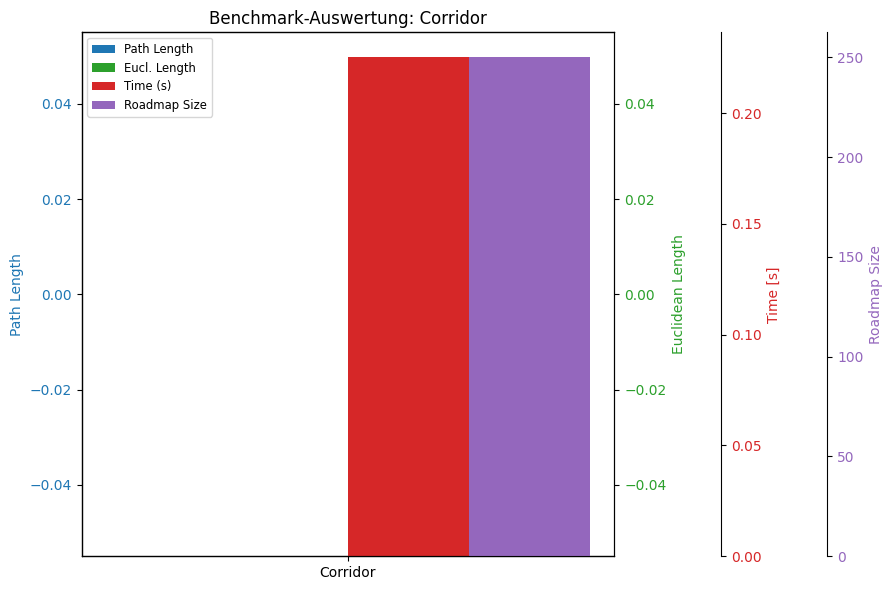

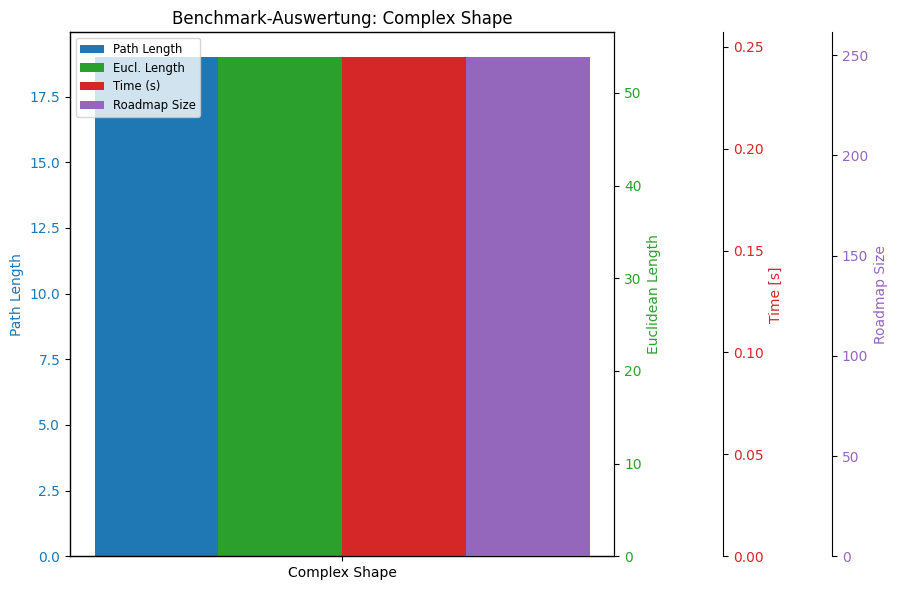

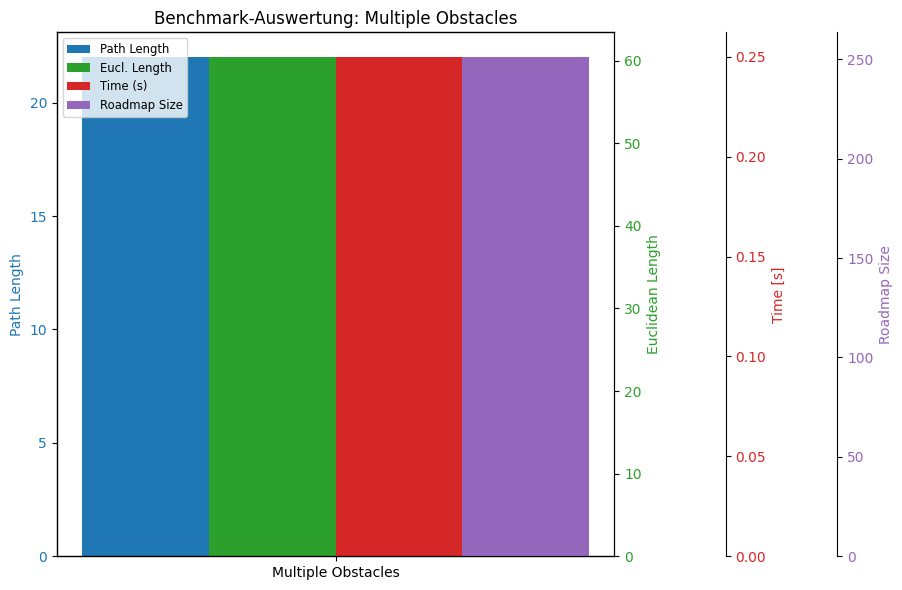

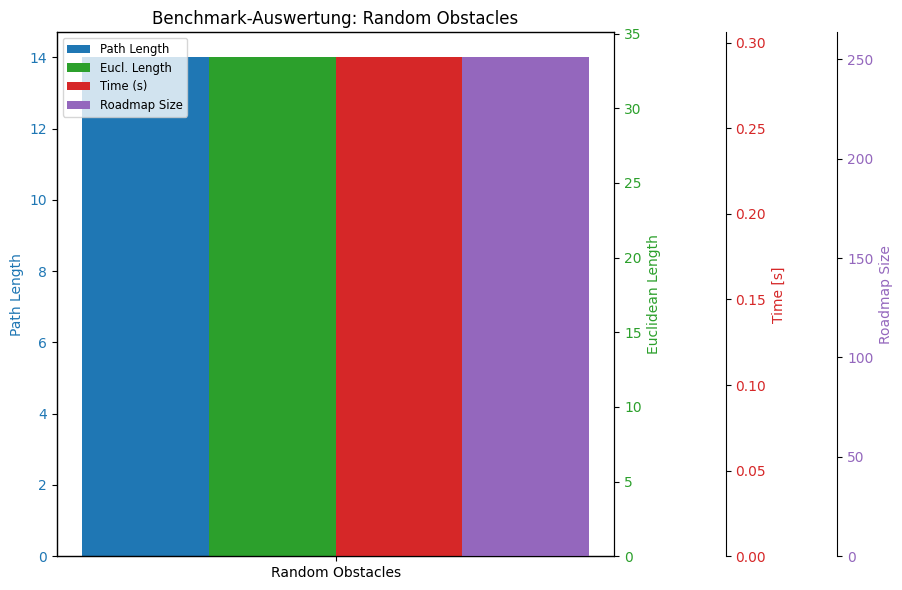

In [18]:
# Ergebnisse als DataFrame
result_df = pd.DataFrame(results)
print("\n📊 Benchmark-Ergebnisse:")
print(result_df)

# Optional: Plot der Auswertung
# Optional: Verbesserte Visualisierung pro Szene
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    width = 0.2
    idx = np.arange(1)

    # Primäre Metriken
    ax1.bar(idx, df["length"], width, label="Path Length", color="#1f77b4")
    ax1.set_ylabel("Path Length", color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")

    # Sekundäre Metrik: euklidische Pfadlänge
    ax2 = ax1.twinx()
    ax2.bar(idx + width, df["euclidean_length"], width, label="Eucl. Length", color="#2ca02c")
    ax2.set_ylabel("Euclidean Length", color="#2ca02c")
    ax2.tick_params(axis='y', labelcolor="#2ca02c")

    # Dritte Achse: Zeit
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.2))
    ax3.bar(idx + 2*width, df["time"], width, label="Time (s)", color="#d62728")
    ax3.set_ylabel("Time [s]", color="#d62728")
    ax3.tick_params(axis='y', labelcolor="#d62728")

    # Vierte Achse: Roadmap-Größe
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('axes', 1.4))
    ax4.bar(idx + 3*width, df["roadmap_size"], width, label="Roadmap Size", color="#9467bd")
    ax4.set_ylabel("Roadmap Size", color="#9467bd")
    ax4.tick_params(axis='y', labelcolor="#9467bd")

    # Achsen und Legenden
    ax1.set_xticks(idx + 1.5 * width)
    ax1.set_xticklabels([scene])
    ax1.set_title(f"Benchmark-Auswertung: {scene}")

    # Alle Legenden vereinen
    handles, labels = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax1.legend(handles, labels, loc="upper left", fontsize="small")

    plt.tight_layout()
    plt.show()

